In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np

from ukbb_data_scripts import constants
from model_helpers import LogitRegression
import global_constants

import itertools

import plotly.graph_objects as go

from multiprocessing import Pool

import scipy.stats as st
import plotly.express as px

In [206]:
def add_ci_filter_mean(df_arg, min_mean=0, filter_by_std=True):
    df = df_arg.sort_values("mean", ascending=False)
    df["phenotype"] = df["phenotype/gene"].apply(lambda x: x.split("/")[0])
    df["gene"] = df["phenotype/gene"].apply(lambda x: x.split("/")[1])
    df["mean_std_difference"] = df["mean"] - df["std"]
    if filter_by_std:
        df = df[df["mean_std_difference"] > 0]
    return df[df["mean"] > min_mean]

In [207]:
def pick_top_phenotype_gene_pairs(df_arg, min_mean=0.05, no_samples=10):
    # takes (by mean_ci_difference) unique phenotype/gene pairs that have mean above min_mean, sorted by subtracting ci from mean
    df = df_arg.sort_values("mean_std_difference", ascending=False)
    df = df[df["mean"] > min_mean].drop_duplicates("phenotype/gene").head(no_samples)
    return df.sort_values("mean", ascending=False)

In [198]:
all_adjusted_phenotypes = pd.read_pickle(constants.all_adjusted_phenotypes_path)

In [208]:
regression_results_df = pd.read_pickle("regression_results_extended.pkl")

In [7]:
regression_results_df = add_ci_filter_mean(regression_results_df, filter_by_std=False)
# with mean above zero
regression_results_df.to_pickle("regression_results_processed.pkl")

In [204]:
regression_results_for_plot = pick_top_phenotype_gene_pairs(regression_results_df[regression_results_df.extended_features == False], min_mean=0.005, no_samples=11)

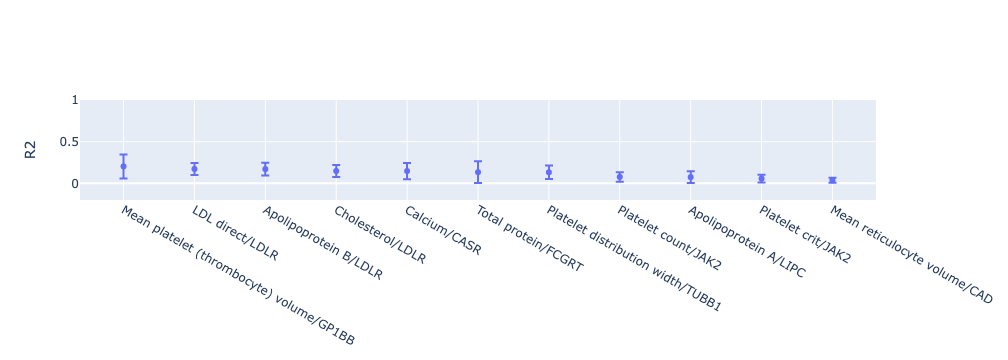

In [205]:
# Linear regression on traits, single feature
fig = go.Figure(data=go.Scatter(
        x=regression_results_for_plot["phenotype/gene"],
        y=regression_results_for_plot["mean"],
        mode='markers',
        error_y=dict(
            type='data',
            array=regression_results_for_plot["std"],
            visible=True)
    ), layout=dict(
        yaxis_title="R2",
        yaxis_range=[-0.2,1]))
fig.show()

In [56]:
# draw feature coverage for comparison, create table
# add varity and REVEL?

In [399]:
def rank_features_single(results_df, num_outputs=20, mean_std_diff_pos=True, height=800):
    if mean_std_diff_pos:
        results_df = results_df[results_df.mean_std_difference > 0]
    af_feature_scores = pd.DataFrame(results_df.groupby(
        "feature")["phenotype/gene"].count().sort_values(ascending=False).head(num_outputs)).rename(
        columns={"phenotype/gene": f"all AF"})
    for maf in sorted(results_df.maf.unique()):
        af_df = pd.DataFrame(results_df[results_df.maf <= maf].groupby(
                    "feature")["phenotype/gene"].count().sort_values(ascending=False)).rename(columns={"phenotype/gene": f"AF {maf}"})
        af_feature_scores = pd.concat((af_feature_scores, af_df), axis=1)
    af_feature_scores.index = af_feature_scores.index.map(lambda x: x.replace("_", " "))
    af_feature_scores = af_feature_scores.head(num_outputs).fillna(0).drop(columns="all AF")
    af_feature_scores = af_feature_scores.iloc[::-1]
    af_feature_scores["AF 0.1"] = af_feature_scores["AF 0.1"] - af_feature_scores["AF 0.01"]
    af_feature_scores["AF 0.01"] = af_feature_scores["AF 0.01"] - af_feature_scores["AF 0.001"]
    af_feature_scores["AF 0.001"] = af_feature_scores["AF 0.001"] - af_feature_scores["AF 0.0001"]
    af_feature_scores = af_feature_scores.reset_index()
    af_feature_scores = pd.melt(af_feature_scores, id_vars=af_feature_scores.columns[0])
    af_feature_scores = af_feature_scores.rename(columns={"variable": "Allele frequency threshold", af_feature_scores.columns[0]: "Variant descriptor", "value": "# trait-gene combinations"})
    fig = px.bar(af_feature_scores, y="Variant descriptor", x="# trait-gene combinations", color="Allele frequency threshold", text="# trait-gene combinations", orientation='h', height=height)
    fig.show()

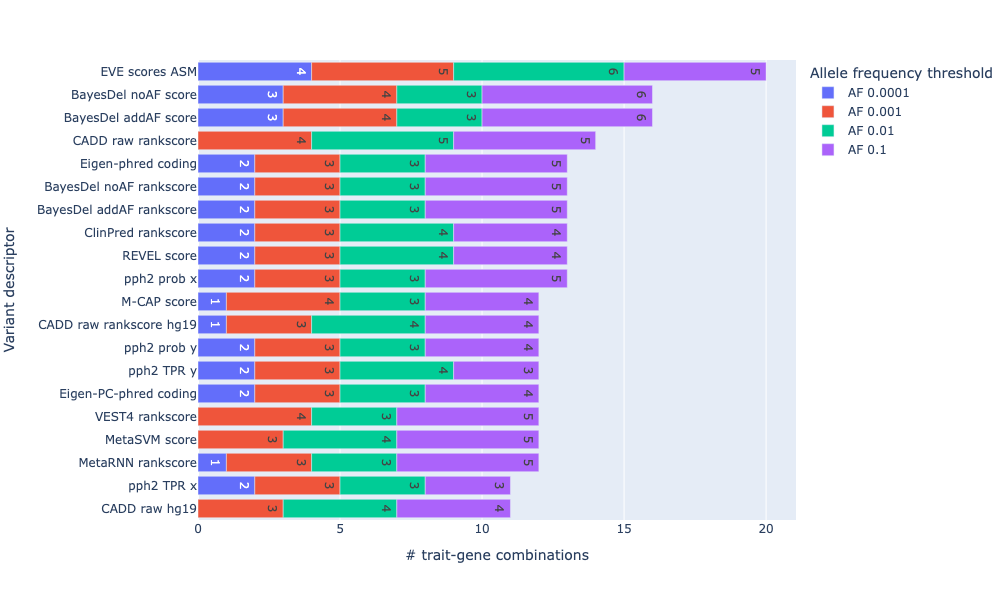

In [413]:
rank_features_single(regression_results_df[regression_results_df.extended_features == False], height=600)

In [421]:
# get EVE coverage
regression_results_df[
    (regression_results_df.extended_features == False) &
    (regression_results_df.mean_std_difference > 0) &
    regression_results_df.feature.apply(lambda x: "EVE_" in x)].drop_duplicates("phenotype/gene")

,phenotype/gene,feature,mean,median,std,#variants,maf,extended_features,phenotype,gene,mean_std_difference
531,Calcium/CASR,EVE_scores_ASM,0.147386,0.159818,0.098048,312,0.1000,False,Calcium,CASR,0.049338
731,Apolipoprotein B/LDLR,EVE_scores_ASM,0.145673,0.147939,0.081374,366,0.0010,False,Apolipoprotein B,LDLR,0.064300
756,LDL direct/LDLR,EVE_scores_ASM,0.142490,0.146211,0.075617,370,0.0010,False,LDL direct,LDLR,0.066873
1350,Cholesterol/LDLR,EVE_scores_ASM,0.112037,0.121856,0.070637,371,0.0010,False,Cholesterol,LDLR,0.041399
3218,Platelet count/JAK2,EVE_scores_ASM,0.076675,0.079856,0.057405,378,0.0001,False,Platelet count,JAK2,0.019270
4899,Platelet crit/JAK2,EVE_scores_ASM,0.061432,0.061016,0.051471,378,0.0001,False,Platelet crit,JAK2,0.009961


In [ ]:
# get BayesDel coverage

In [32]:
# prediction as a function of allele frequency?

In [87]:
all_adjusted_phenotypes_path = pd.read_pickle(constants.all_adjusted_phenotypes_path)

In [90]:
all_adjusted_phenotypes_path["num_genes"] = all_adjusted_phenotypes_path.genes.apply(len)

In [163]:
num_traits = 20
adjustment_barplot = all_adjusted_phenotypes_path.sort_values("adjustment_r2", ascending=False)[["adjustment_r2", "phenotype"]].head(num_traits).round(2)

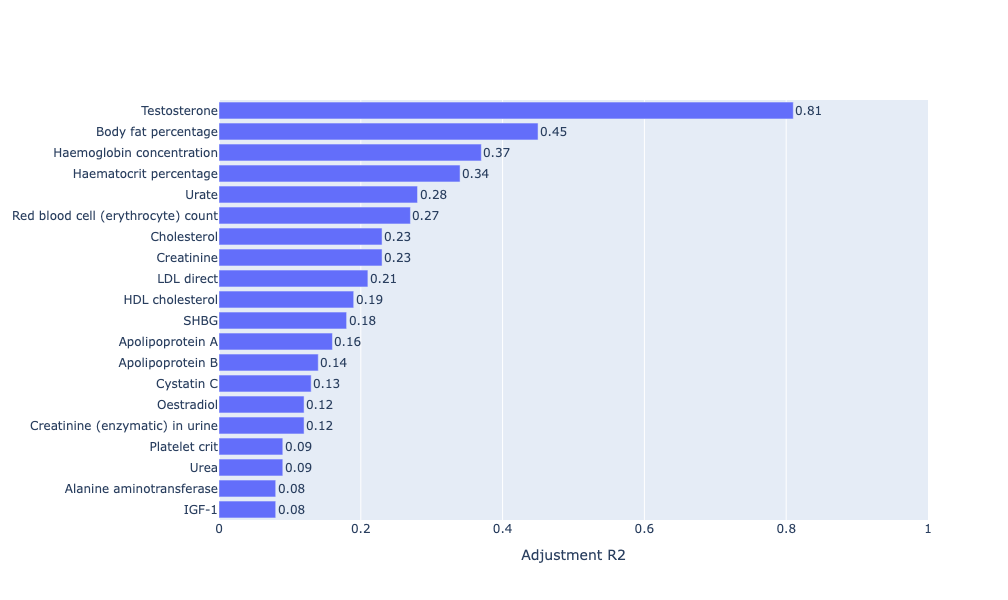

In [165]:
# can split by contribution (e.g. max value times weight)
annotationsList = [dict(
                x=xi,
                y=yi,
                text=str(xi),
                xanchor='left',
                yanchor='auto',
                showarrow=False,
            ) for xi, yi in zip(adjustment_barplot.adjustment_r2[::-1], range(num_traits))]

fig = go.Figure(go.Bar(
            x=adjustment_barplot.adjustment_r2[::-1],
            y=adjustment_barplot.phenotype[::-1],
            orientation='h'),
               layout={"xaxis_range": (0, 1),
                      "annotations": annotationsList,
                      "xaxis_title": "Adjustment R2",
                      "height": 600})

fig.show()

In [128]:
feature_coverage_hist_data = (1 - variant_features_all[filter(lambda x: x[-3:] == "_na", variant_features_all.columns.tolist())].sum(axis=0)/len(variant_features_all))

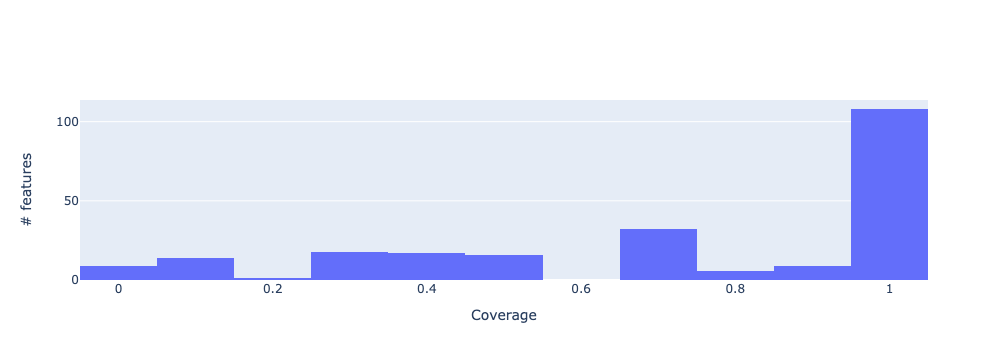

In [133]:
fig = go.Figure(data=[go.Histogram(x=feature_coverage_hist_data)],
               layout={"xaxis_title_text": 'Coverage',
                      "yaxis_title_text": '# features'})
fig.show()

In [837]:
# generate a single dataframe with these phenotype/gene pairs

all_vars_phenotypes_df = None
for phenotype in regression_results_df.phenotype.unique():
    vars_df = pd.read_pickle(all_adjusted_phenotypes[all_adjusted_phenotypes.phenotype == phenotype].var_phenotype_path.iloc[0])
    vars_df = vars_df[vars_df.gene.isin(regression_results_df[regression_results_df.phenotype == phenotype].gene.unique())]
    vars_df["phenotype"] = phenotype
    phenotype_continuous = all_adjusted_phenotypes[all_adjusted_phenotypes.phenotype == phenotype].type.iloc[0] == "continuous"
    if phenotype_continuous:
        vars_df = vars_df.drop(columns=["mean", "std", "median/phenotype_std", "median/gene_medians_std"]).rename(columns={"median": "predictand"})
    else:
        vars_df = vars_df.drop(columns=["median", "std", "median/phenotype_std", "median/gene_medians_std"]).rename(columns={"mean": "predictand"})
    vars_df["phenotype_continuous"] = phenotype_continuous
    if all_vars_phenotypes_df is None:
        all_vars_phenotypes_df = vars_df
    else:
        all_vars_phenotypes_df = pd.concat((all_vars_phenotypes_df, vars_df), axis=0)
variant_features_all = pd.read_pickle(constants.variant_features_all)
all_vars_phenotypes_df = all_vars_phenotypes_df.merge(variant_features_all[["var_id"] + constants.all_cat_cols \
                                                      + constants.all_cont_cols + list(map(lambda x: x + "_na", constants.all_cont_cols))],
                                                      on="var_id", how="left")
all_vars_phenotypes_df.to_pickle(global_constants.top_regression_vars_phenotypes_path)

In [ ]:
# list all of the variant features we use
features_list = list(sorted(filter(lambda x: x[-3:] != "_na", variant_features_all.columns.tolist()[1:])))
print(pd.DataFrame(np.array(features_list + [-1]).reshape((-1, 2))).to_latex(index=False, header=False))

## Execute multi feature regression before proceeding

In [ ]:
!python execute_greedy_multi_feature_regression.py

In [220]:
multi_feature_regression_results_df = pd.read_pickle("regression_greedy_multi_feature.pkl")

multi_feature_regression_results_df = add_ci_filter_mean(multi_feature_regression_results_df, min_mean=0.005)

multi_feature_regression_results_for_plot = pick_top_phenotype_gene_pairs(multi_feature_regression_results_df)

In [ ]:
print(multi_feature_regression_results_df[
    (multi_feature_regression_results_df.mean_std_difference > 0)].drop_duplicates("phenotype/gene")[
    ["phenotype", "gene", "mean", "std", "#variants", "maf"]].reset_index(drop=True).to_latex())


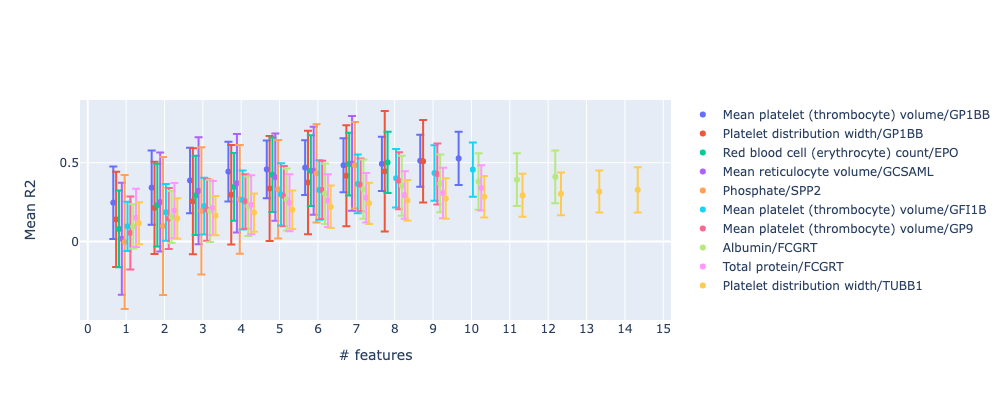

In [464]:
# generate plots for top 10 multi_feature_regression_results_df combinations
fig = go.Figure()
jitter = np.linspace(-1, 1, num=len(multi_feature_regression_results_for_plot))/3
for i, row in enumerate(multi_feature_regression_results_for_plot.iterrows()):
#     print(row[1])
    row = row[1]
    fig.add_trace(go.Scatter(name=row["phenotype/gene"],
                            x=list(range(1, len(row.r2_mean_history) + 1)) + jitter[i],
                            y=row.r2_mean_history,
                            mode="markers",
                            error_y=dict(
                                type='data',
                                array=row.r2_std_history,
                                visible=True,
                                )))
fig.update_layout(
    yaxis_title='Mean R2',
    xaxis_title="# features",
    xaxis={"tickmode": 'linear'},
    height=400
)
fig.show()

In [332]:
# use only up to n features
def reduce_features(results_df, num_features):
    feature_df = results_df.copy()
    feature_df.features = feature_df["features"].apply(lambda x: list(x[:num_features]))
    feature_df.r2_mean_history = feature_df.r2_mean_history.apply(lambda x: list(x[:num_features]))
    feature_df.r2_std_history = feature_df.r2_std_history.apply(lambda x: list(x[:num_features]))
    feature_df["mean"] = feature_df.r2_mean_history.apply(lambda x: x[-1])
    feature_df["std"] = feature_df.r2_std_history.apply(lambda x: x[-1])
    feature_df.mean_std_difference = feature_df["mean"] - feature_df["std"]
    feature_df.drop(columns="median", inplace=True)
    return feature_df.sort_values("mean", ascending=False)

In [491]:
def rank_features_multi(results_df, max_no_features=100, num_outputs=20, mean_std_diff_pos=True, height=800, plot=True):
    results_df = reduce_features(results_df, num_features=max_no_features)
    if mean_std_diff_pos:
        results_df = results_df[results_df.mean_std_difference > 0]
    af_feature_scores = pd.DataFrame(results_df.explode("features").groupby(
        "features")["phenotype/gene"].count().sort_values(ascending=False).head(num_outputs)).rename(
        columns={"phenotype/gene": f"all AF"})
    for maf in sorted(results_df.maf.unique()):
        af_df = pd.DataFrame(results_df[results_df.maf <= maf].explode("features").groupby(
                    "features")["phenotype/gene"].count().sort_values(ascending=False)).rename(columns={"phenotype/gene": f"AF {maf}"})
        af_feature_scores = pd.concat((af_feature_scores, af_df), axis=1)
    af_feature_scores.index = af_feature_scores.index.map(lambda x: x.replace("_", " "))
    af_feature_scores = af_feature_scores.head(num_outputs).fillna(0).drop(columns="all AF")
    af_feature_scores = af_feature_scores.iloc[::-1]
    af_feature_scores["AF 0.1"] = af_feature_scores["AF 0.1"] - af_feature_scores["AF 0.01"]
    af_feature_scores["AF 0.01"] = af_feature_scores["AF 0.01"] - af_feature_scores["AF 0.001"]
    af_feature_scores["AF 0.001"] = af_feature_scores["AF 0.001"] - af_feature_scores["AF 0.0001"]
    af_feature_scores = af_feature_scores.reset_index()
    af_feature_scores = pd.melt(af_feature_scores, id_vars=af_feature_scores.columns[0])
    af_feature_scores = af_feature_scores.rename(columns={"variable": "Allele frequency threshold", af_feature_scores.columns[0]: "Variant descriptor", "value": "# trait-gene combinations"})
    if plot:
        fig = px.bar(af_feature_scores, y="Variant descriptor", x="# trait-gene combinations", color="Allele frequency threshold", text="# trait-gene combinations", orientation='h', height=height)
        fig.show()
    else:
        return af_feature_scores

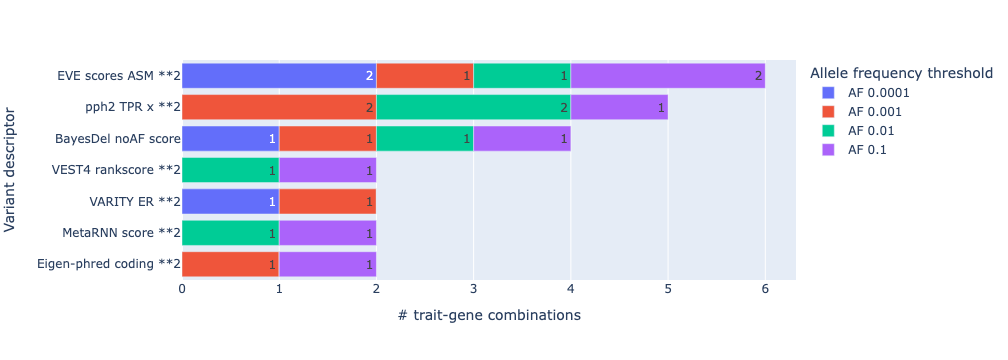

In [367]:
rank_features_multi(multi_feature_regression_results_df, max_no_features=1, num_outputs=7, height=None)

In [503]:
def rank_features_multi_final(results_df, max_no_features=100, num_outputs=20, mean_std_diff_pos=True, height=800, plot=True):
    results_df = reduce_features(results_df, num_features=max_no_features)
    if mean_std_diff_pos:
        results_df = results_df[results_df.mean_std_difference > 0]
    af_feature_scores = results_df.explode("features")
    af_feature_scores["features"] = af_feature_scores["features"].apply(lambda x: x[:-4] if x[-4:] == "_**2" else x)
    af_feature_scores["features"] = af_feature_scores["features"].apply(lambda x: x[:-4] if x[-4:] == "_log" else x)
    af_feature_scores["features"] = af_feature_scores["features"].apply(lambda x: x[:-3] if x[-3:] == "_na" else x)
    af_feature_scores = pd.DataFrame(af_feature_scores.groupby(
        "features")["phenotype/gene"].count().sort_values(ascending=False).head(num_outputs)).rename(
        columns={"phenotype/gene": f"all AF"})
    af_feature_scores.index = af_feature_scores.index.map(lambda x: x.replace("_", " "))
    af_feature_scores = af_feature_scores.head(num_outputs)
    af_feature_scores = af_feature_scores.reset_index()
    af_feature_scores = af_feature_scores.iloc[::-1]
    af_feature_scores = af_feature_scores.rename(columns={"features": "Variant descriptor", "all AF": "# trait-gene combinations"})
    if plot:
        fig = px.bar(af_feature_scores, y="Variant descriptor", x="# trait-gene combinations", text="# trait-gene combinations", orientation='h', height=height)
        fig.show()
    else:
        return af_feature_scores

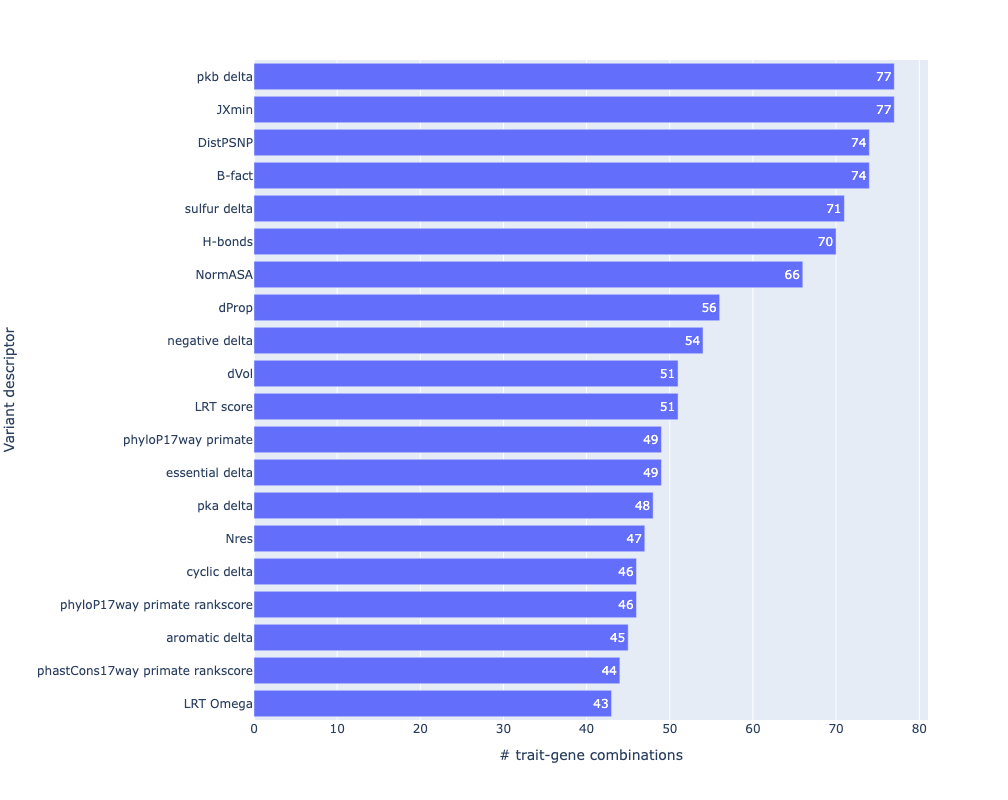

In [504]:
rank_features_multi_final(multi_feature_regression_results_df)

In [507]:
feature_ranking_df = rank_features_multi_final(multi_feature_regression_results_df, plot=False, num_outputs=999999)

In [ ]:
print(feature_ranking_df.iloc[::-1].to_latex())

In [217]:
regression_results_df_for_plot = regression_results_df.sort_values("mean_std_difference", ascending=False)
regression_results_df_for_plot = regression_results_df_for_plot.drop_duplicates("phenotype/gene")
regression_results_df_for_plot = regression_results_df_for_plot.merge(multi_feature_regression_results_for_plot[["phenotype/gene"]], how="right")

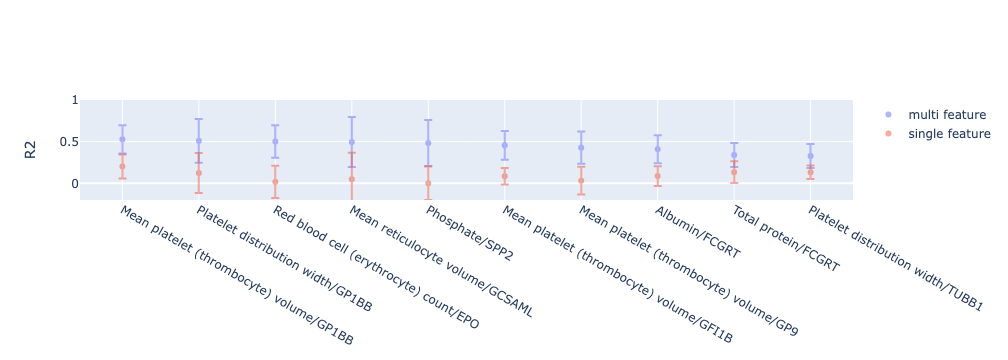

In [247]:
fig = go.Figure(data=[go.Scatter(
        x=multi_feature_regression_results_for_plot["phenotype/gene"],
        y=multi_feature_regression_results_for_plot["mean"],
        mode='markers',
        opacity=.5,
        name="multi feature",
        error_y=dict(
            type='data',
            array=multi_feature_regression_results_for_plot["std"],
            visible=True)
    ), go.Scatter(
        x=regression_results_df_for_plot["phenotype/gene"],
        y=regression_results_df_for_plot["mean"],
        mode='markers',
        opacity=.5,
        name="single feature",
        error_y=dict(
            type='data',
            array=regression_results_df_for_plot["std"],
            visible=True))],
    layout=dict(
#         title="Linear regression on traits, multiple features",
        yaxis_title="R2",
        yaxis_range=[-0.2,1]))
fig.show()

In [249]:
# see for how many pairs there is improvement in mean, for how many mean ci differences are higher
joint_single_multi = regression_results_df.sort_values("mean", ascending=False).drop_duplicates("phenotype/gene").merge(
    multi_feature_regression_results_df.sort_values("mean", ascending=False).drop_duplicates("phenotype/gene"), on="phenotype/gene", how="left")


In [250]:
print(f"We see higher mean R2 in {len(joint_single_multi[joint_single_multi.mean_x < joint_single_multi.mean_y]) / len(joint_single_multi):.2f}%\
 of phenotype-gene pairs when using multiple features (out of {len(joint_single_multi)} pairs) and in \
{(len(joint_single_multi[joint_single_multi.mean_x - joint_single_multi.std_x < joint_single_multi.mean_y - joint_single_multi.std_y])) / len(joint_single_multi):.2f}%\
 'mean R2 - R2 std dev' difference is higher. Note that standard deviation is also higher in {len(joint_single_multi[joint_single_multi.std_x < joint_single_multi.std_y])/len(joint_single_multi):.2f}%.")


We see higher mean R2 in 0.46% of phenotype-gene pairs when using multiple features (out of 524 pairs) and in 0.46% 'mean R2 - R2 std dev' difference is higher. Note that standard deviation is also higher in 0.41%.


In [251]:
# the trait-gene pairs that have mean higher in multi-feature scenario but not in the single-feature one
set(multi_feature_regression_results_df[multi_feature_regression_results_df["mean"] > multi_feature_regression_results_df["std"]].drop_duplicates(
    "phenotype/gene")["phenotype/gene"].unique()).difference(
    regression_results_df[regression_results_df["mean"] > regression_results_df["std"]].drop_duplicates("phenotype/gene")["phenotype/gene"].unique())

{'20004/TMEM176A',
 'Age when periods started (menarche)/MC3R',
 'Albumin/FCGRT',
 'Albumin/SCAF1',
 'Alkaline phosphatase/EDEM1',
 'Alkaline phosphatase/FCGRT',
 'Alkaline phosphatase/SLC17A4',
 'Alkaline phosphatase/SULT2B1',
 'Alkaline phosphatase/VWA5B1',
 'Apolipoprotein A/CD36',
 'Apolipoprotein A/CETP',
 'Apolipoprotein A/FCGRT',
 'Apolipoprotein A/HNF4A',
 'Apolipoprotein A/LIPG',
 'Apolipoprotein A/LPL',
 'Apolipoprotein A/NEK7',
 'Apolipoprotein A/NR1H3',
 'Apolipoprotein A/PPARG',
 'Apolipoprotein B/APOE',
 'Apolipoprotein B/BCAM',
 'Apolipoprotein B/FGB',
 'Apolipoprotein B/PCSK9',
 'Apolipoprotein B/PPP1R37',
 'Apolipoprotein B/PVR',
 'Apolipoprotein B/SLC22A3',
 'Apolipoprotein B/UGT2B7',
 'Basophill count/SLC9A3R1',
 'Body fat percentage/PPARG',
 'Calcium/ALB',
 'Calcium/ALPL',
 'Calcium/FCGRT',
 'Calcium/SCAF1',
 'Calcium/SLC15A2',
 'Cholesterol/APOE',
 'Cholesterol/FCGRT',
 'Cholesterol/LIPC',
 'Cholesterol/PCSK9',
 'Cholesterol/PVR',
 'Creatinine/SCYL1',
 'Creatinine/

In [252]:
# check if there are any phenotype/gene pairs where mean R2 is greater than std and that are better predicted with a single feature
better_single_set = set(regression_results_df[regression_results_df["mean"] > regression_results_df["std"]].drop_duplicates("phenotype/gene")["phenotype/gene"].unique()).difference(
    multi_feature_regression_results_df[multi_feature_regression_results_df["mean"] > multi_feature_regression_results_df["std"]].drop_duplicates(
    "phenotype/gene")["phenotype/gene"].unique())
better_single_set

set()

# Show the per-individual trait variability

In [545]:
from sklearn.metrics import r2_score

In [564]:
data_list = []
for row in all_adjusted_phenotypes_path[
        all_adjusted_phenotypes_path.type == "continuous"].iterrows():
    row = row[1]
    cur_df = pd.read_pickle(row.adjusted_path)
    
    if "assessment" in cur_df.columns and cur_df.assessment.astype(int).max() > 0:
        cur_df.assessment = cur_df.assessment.astype(int)
        all_assessments_df = None
        for i in range(1, cur_df.assessment.max() + 1):
            for j in range(i):
                merged_df = cur_df[cur_df.assessment == i].merge(cur_df[cur_df.assessment == j], on="eid")
                if all_assessments_df is None: 
                    all_assessments_df = merged_df
                else:
                    all_assessments_df = pd.concat((all_assessments_df, merged_df), axis=0)
        r2_input = all_assessments_df[["adjusted_x", "adjusted_y"]].values
        [np.random.shuffle(x) for x in r2_input]
        cur_r2 = r2_score(r2_input[:,0], r2_input[:,1])
        data_list.append((row.phenotype, len(r2_input), cur_r2))

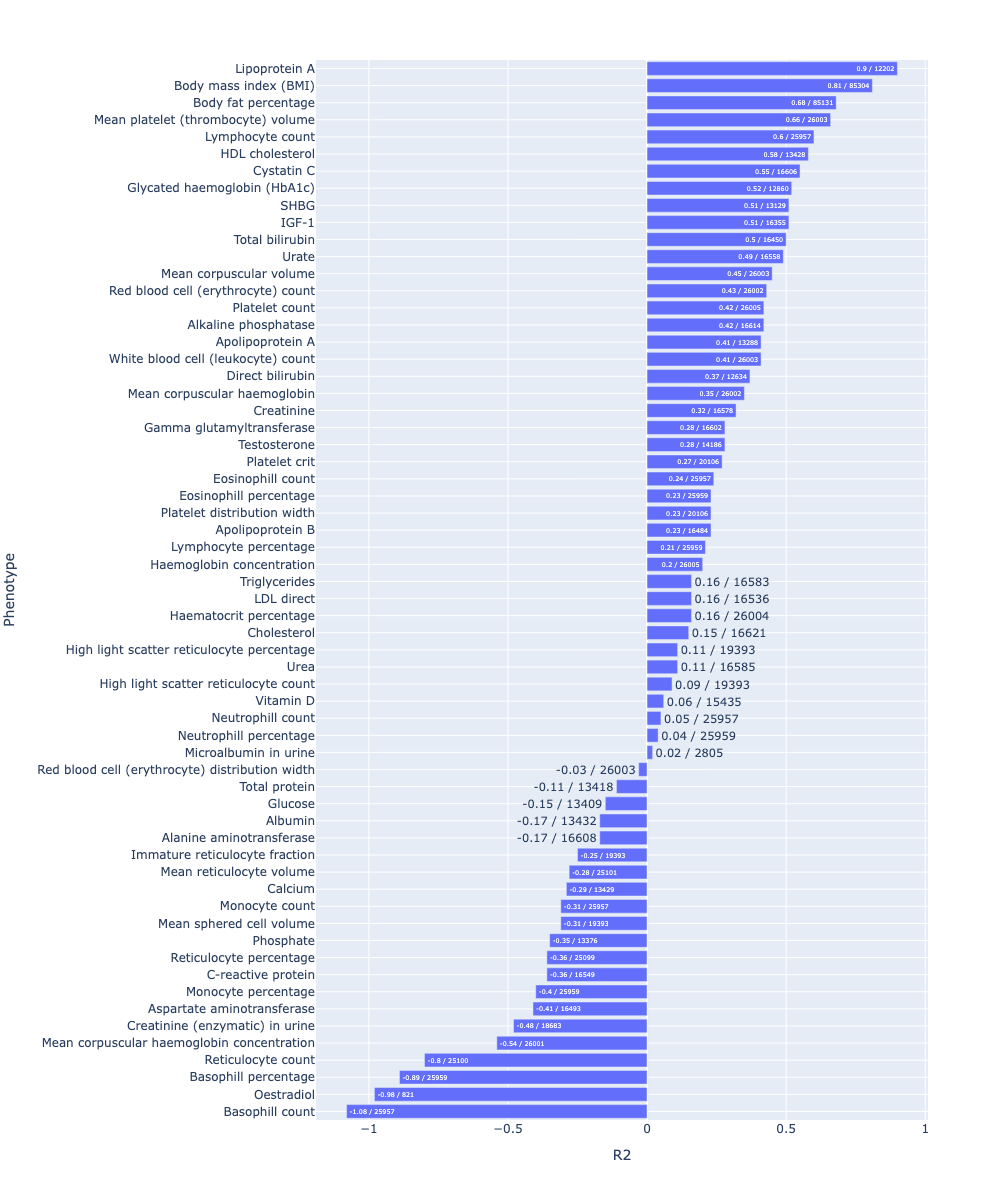

In [587]:
trait_variability = pd.DataFrame(data_list, columns=["Phenotype", "# samples", "R2"])[["Phenotype", "R2", "# samples"]].sort_values("R2", ascending=False).drop_duplicates("Phenotype").reset_index(drop=True)
trait_variability = trait_variability.iloc[::-1]
trait_variability = trait_variability.round(2)
trait_variability["R2 / # samples"] = trait_variability.R2.apply(str) + " / " + trait_variability["# samples"].apply(str)
fig = px.bar(trait_variability, y="Phenotype", x="R2", text="R2 / # samples", orientation='h', height=1200)
fig.update_yaxes(nticks=len(trait_variability), showgrid=True)
fig.show()

# Show feature distribution

In [601]:
# first only the phenotype/gene combinations from the plot
combinations_hist = []
for phenotype_gene in multi_feature_regression_results_for_plot["phenotype/gene"]:
    phenotype, gene = phenotype_gene.split("/")
    cur_pkl = pd.read_pickle(all_adjusted_phenotypes_path[
        all_adjusted_phenotypes_path.phenotype == phenotype].iloc[0].var_phenotype_path)
    cur_means = cur_pkl[cur_pkl.gene == gene]["mean"]
    combinations_hist.append((phenotype_gene, cur_means.values))
# then, for supplementary materials, all

In [597]:
import matplotlib.pyplot as plt

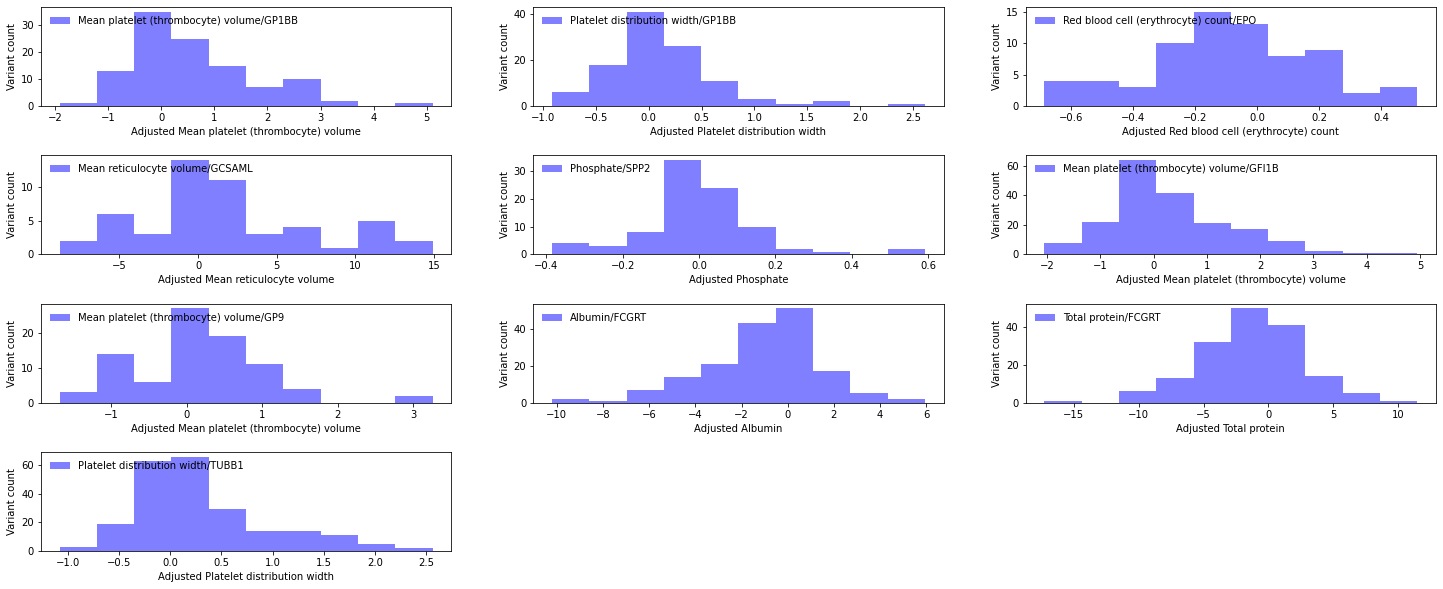

In [615]:
# Generically define how many plots along and across
ncols = 3
nrows = int(np.ceil(len(combinations_hist) / (1.0*ncols)))
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(25, 10))

# Lazy counter so we can remove unwated axes
counter = 0
for i in range(nrows):
    for j in range(ncols):

        ax = axes[i][j]

        # Plot when we have data
        if counter < len(combinations_hist):

            ax.hist(combinations_hist[counter][1], bins=10, color='blue', alpha=0.5, label='{}'.format(combinations_hist[counter][0]))
            ax.set_xlabel(f'Adjusted {combinations_hist[counter][0].split("/")[0]}')
            ax.set_ylabel('Variant count')
            leg = ax.legend(loc='upper left')
            leg.draw_frame(False)

        # Remove axis when we no longer have data
        else:
            ax.set_axis_off()

        counter += 1
plt.subplots_adjust(hspace = 0.5)
plt.savefig('top_trait_gene.pdf')  

In [626]:
combinations_hist = []
for phenotype_gene in multi_feature_regression_results_df.drop_duplicates("phenotype/gene")["phenotype/gene"]:
    phenotype, gene = phenotype_gene.split("/")
    cur_pkl = pd.read_pickle(all_adjusted_phenotypes_path[
        all_adjusted_phenotypes_path.phenotype == phenotype].iloc[0].var_phenotype_path)
    cur_means = cur_pkl[cur_pkl.gene == gene]["mean"]
    combinations_hist.append((phenotype_gene, cur_means.values))

In [633]:
import math

In [ ]:
# Generically define how many plots along and across
ncols = 3
nrows = int(np.ceil(len(combinations_hist) / (1.0*ncols)))
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(25, 10 * math.ceil(len(combinations_hist)/3/2)))

# Lazy counter so we can remove unwated axes
counter = 0
for i in range(nrows):
    for j in range(ncols):

        ax = axes[i][j]

        # Plot when we have data
        if counter < len(combinations_hist):

            ax.hist(combinations_hist[counter][1], bins=10, color='blue', alpha=0.5, label='{}'.format(combinations_hist[counter][0]))
            ax.set_xlabel(f'Adjusted {combinations_hist[counter][0].split("/")[0]}')
            ax.set_ylabel('Variant count')
            leg = ax.legend(loc='upper left')
            leg.draw_frame(False)

        # Remove axis when we no longer have data
        else:
            ax.set_axis_off()

        counter += 1
plt.subplots_adjust(hspace = 0.5)
plt.savefig('more_trait_gene_histograms.pdf')  